# Dimensionality reduction via PCA, kPCA, and LDA


Both Linear Discriminant Analysis (LDA) and Principal Components Analysis (PCA) are linear transformation methods. Kernel PCA (kPCA) first transforms the data with a non-linear kernel, then performs PCA; thus it can find non-linear components.

PCA and kPCA yield the directions (components) in the vector space that maximize the variance of the data. They do not use any supervised labelling. Whereas LDA aims to find the components that maximizes the separation between classes using a set of supervised labels. 

LDA assumes that all classes have different means but the same covariance structure. PCA and kPCA assume that the main source of variance in the data is signal and not noise. Both LDA and PCA assume that a linear transformation of the data space is sufficient to expose important patterns. Make sure your dataset/problem matches these assumptions!

For data which is $ n \times d$, PCA and LDA transform the data into $n \times d$ components. These components are transformations of the original data's vector space. In contrast kPCA transforms the data into an $n \times n$ similarity matrix before calculating its components, so it ends up with $n \times n$ matrix in component space and is much more computationally intensive for large $n$, low $d$ problems.  In all three algorithms we can tranform data from the original data space into the component space and back again. 

Dimensionality reduction is the process of taking a subset of the $d$ (or $n$ for kPCA) components and using them to reconstruct the data.  All three algorithms have a concept of "most useful" components that best describe the optimization criteria of the algorithm, so we wll take only the most useful components in our subset.  For PCA/kPCA that's the components with the largest eigenvalues because they capture the most variance in the data. For LDA that's the components that produce the best posterior probability of correct 
classification. 


## Datasets

I'll load three datasets of this task, penguins, MNIST and a dataset of measurements of normal and cancerous cells. 


In [53]:
# basic data utils
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
pal = sns.color_palette("hls", 10)

# Dimension reduction and clustering tools
import sklearn.cluster as cluster
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Data loading
from sklearn.datasets import fetch_openml

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Metrics for how good a clustering does
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, classification_report

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(int)

count    70000.000000
mean         4.452429
std          2.890195
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: class, dtype: float64

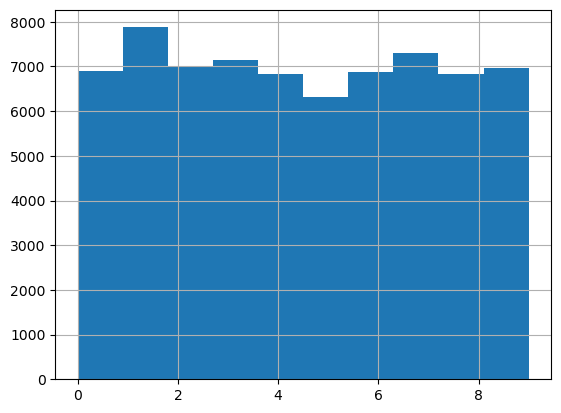

In [3]:
# we should know as much as possible about our datasets... it will influence how we use it

# lets start by seeing something about the distribution of classes
mnist.target.hist();
mnist.target.describe()

count    5.488000e+07
mean     3.338596e+01
std      7.865437e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.550000e+02
dtype: float64

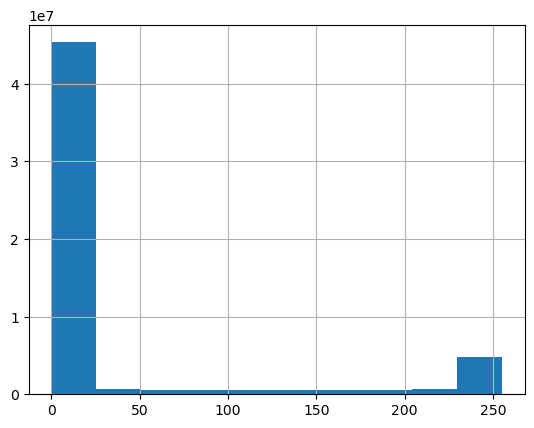

In [4]:
# now lets see something about the distribution of pixel values

# take all pixels in all images, put them in one lump
pix = pd.Series( mnist.data.values.reshape(-1) )

# so we can examine the values of these grayscale pixels
pix.hist()
pix.describe()

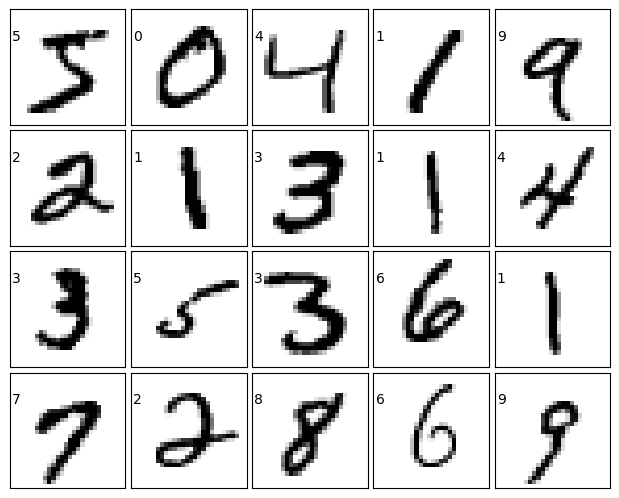

In [5]:
# examples of the raw data

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(20):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    # data is 28 x 28 pixels, grayscale
    ax.imshow(mnist.data.loc[i].to_numpy().reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(mnist.target.loc[i]))

In [6]:
# lets get some 🐧 data to work with
penguins = sns.load_dataset("penguins").dropna()
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [11]:
penguins[['species','sex','island']].value_counts()

species    sex     island   
Gentoo     Male    Biscoe       61
           Female  Biscoe       58
Chinstrap  Female  Dream        34
           Male    Dream        34
Adelie     Male    Dream        28
           Female  Dream        27
                   Torgersen    24
           Male    Torgersen    23
           Female  Biscoe       22
           Male    Biscoe       22
dtype: int64

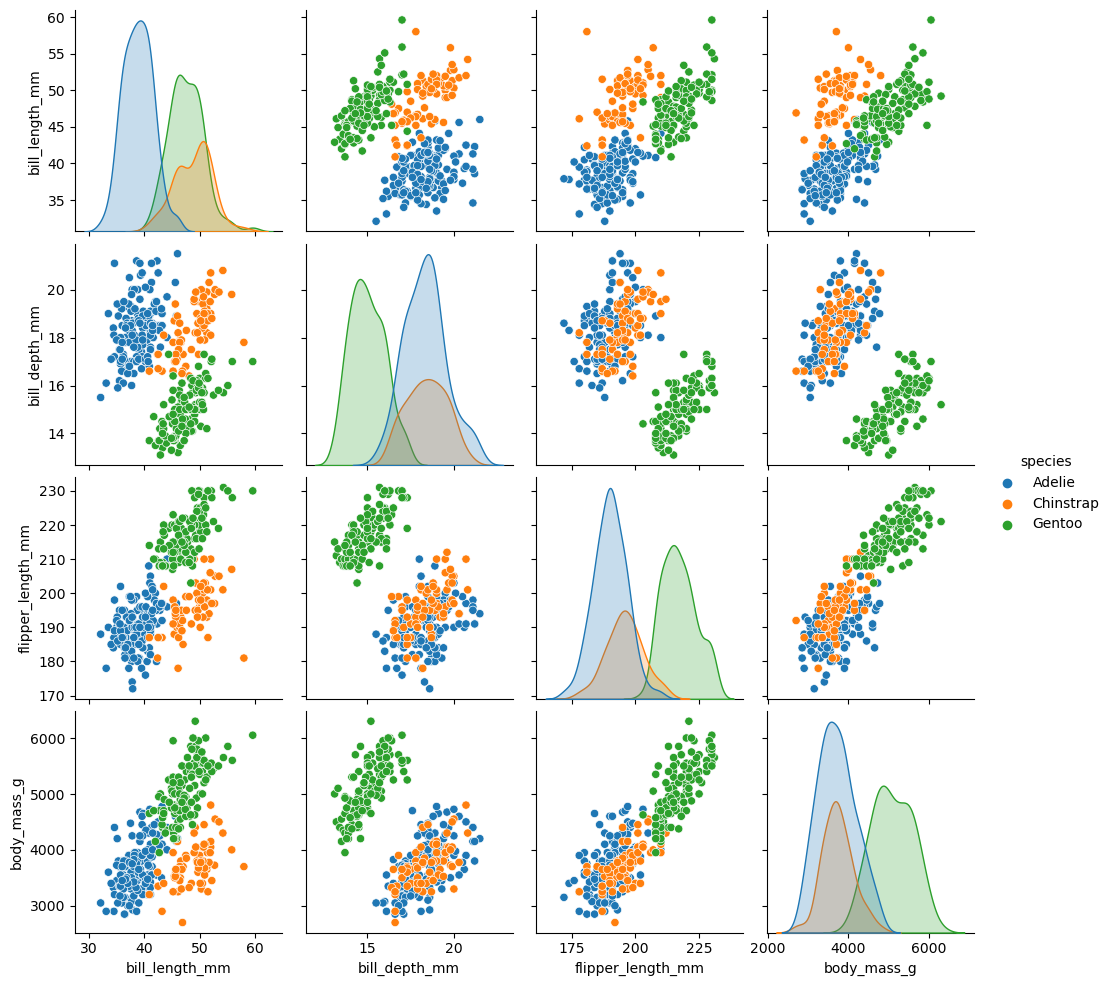

In [14]:
sns.pairplot(penguins,hue='species');

In [20]:
cancer = fetch_openml('Wisconsin-breast-cancer-cytology-features', version=1)
cancer.target = cancer.data['class']
cancer.data = cancer.data.drop(columns='class')

In [38]:
print(cancer.DESCR)

Context
Cytology features of breast cancer biopsy. It can be used to predict breast cancer from cytology features.
The data was obtained from https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original) 
Data description can be found at https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names
Content
Data contains cytology features of breast cancer biopsies - clump thickness, uniformity of cell size, uniformity of cell shape, marginal adhesion, single epithelial cell size, bare nuclei, bland chromatin, normal nuceloli, mitosis. The class variable denotes whether it was cancer or not. Cancer = 1 and not cancer = 0
Attribute Information:

Sample code number: id number 
Clump Thickness: 1 - 10 
Uniformity of Cell Size: 1 - 10 
Uniformity of Cell Shape: 1 - 10 
Marginal Adhesion: 1 - 10 
Single Epithelial Cell Size: 1 - 10 
Bare Nuclei: 1 - 10 
Bland Chromatin: 1 - 10 
Normal Nucleoli: 1 - 10 
Mitoses: 1 - 10 
Class: (0 f

In [24]:
cancer.data.drop(columns='id').describe()

,thickness,size,shape,adhesion,single,nuclei,chromatin,nucleoli,mitosis
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [32]:
# some people are in the dataset more than once
# these are so called technical replicates... multiple measurements of the same persons cells
print(cancer.data.id.unique().shape[0],'unique people in the raw dataset')

# but lets get rid of them anyway to make our lives easier
cancer.data = cancer.data.drop_duplicates(subset=['id'])

645 unique people in the raw dataset


In [34]:
cancer.data.shape

(645, 10)

## Tasks

Lets use some or all of those datasets to explore the following

1. PCA / kPCA / LDA dimensionality reduction to 2 dim for visualization
    - View the PC loadings to analyze what the components are
1. Classification via LDA (which uses all the components in sklearn)
    - cross validation performance
1. Model selection for number of PCs to capture most of the variability
    - in sample: pick the elbow of % variance explained or pick a fixed threshold of % variance explained
1. Clustering on top of the selected number of PCs
    - in sample: as above + BIC (or similar) of clustering model on top
    - grid search cros validation of pipeline params of preproc + dr + clustering
1. Using dimensionality reduction as a novelty/outlier detector
    - train on training set, visualize on test
    
    
### Task 1: visualization

In [47]:
pca = PCA(n_components=2)
kpca = KernelPCA(n_components=2, kernel='linear', gamma=1e-10, degree=3, eigen_solver='randomized')
lda = LinearDiscriminantAnalysis(n_components=2)
scaler = StandardScaler() # other choices are available!!
onehot = OneHotEncoder()

dataset = mnist.data
target = mnist.target
to_scale = dataset.columns[ dataset.dtypes == float ]
to_onehot = dataset.columns[ dataset.dtypes == object ]
scaled = scaler.fit_transform(dataset[to_scale])
cats = onehot.fit_transform(dataset[to_onehot])
print(f'numeric features: {to_scale.shape[0]}\tcategorical features: {to_onehot.shape[0]}')
preproc = pd.DataFrame(scaled, columns=scaler.get_feature_names_out())
preproc = preproc.join( pd.DataFrame(cats.toarray(), 
                            columns=onehot.get_feature_names_out(), 
                            index=preproc.index))
preproc

numeric features: 784	categorical features: 0


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.032951,-0.023387,-0.01675,-0.010638,-0.008339,-0.005342,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.032951,-0.023387,-0.01675,-0.010638,-0.008339,-0.005342,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.032951,-0.023387,-0.01675,-0.010638,-0.008339,-0.005342,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.032951,-0.023387,-0.01675,-0.010638,-0.008339,-0.005342,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.032951,-0.023387,-0.01675,-0.010638,-0.008339,-0.005342,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.032951,-0.023387,-0.01675,-0.010638,-0.008339,-0.005342,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.032951,-0.023387,-0.01675,-0.010638,-0.008339,-0.005342,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.032951,-0.023387,-0.01675,-0.010638,-0.008339,-0.005342,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.032951,-0.023387,-0.01675,-0.010638,-0.008339,-0.005342,0.0,0.0,0.0,0.0


In [48]:
# sklearn pca DOES automatically 0-center inputs but does NOT scale
# note that particularly for kernelPCA we need to sample a subset of the dataset
# because kernelPCA builds a NxN matrix which is very computationally expensive

red = pca.fit_transform(dataset) 
# or try any of the following
# red = pca.fit_transform(preproc)
# red = kpca.fit_transform(dataset.sample(5000)) # adjust subsampling according to dataset!
# red = kpca.fit_transform(preproc.sample(5000)) # adjust subsampling according to dataset!
# red = lda.fit_transform(dataset, target)
# red = lda.fit_transform(preproc, target)


reduced = pd.DataFrame(red, columns=['pc1','pc2']).join(target)
reduced

,pc1,pc2,class
0,122.252671,-316.267394,5
1,1010.494682,-289.935307,0
2,-58.993586,393.746763,4
3,-796.967556,-607.482195,1
4,-391.317412,729.844857,9
...,...,...,...
69995,305.691653,-549.691652,2
69996,569.185916,-699.025958,3
69997,-271.507103,590.069417,4
69998,-310.224904,-116.759057,5


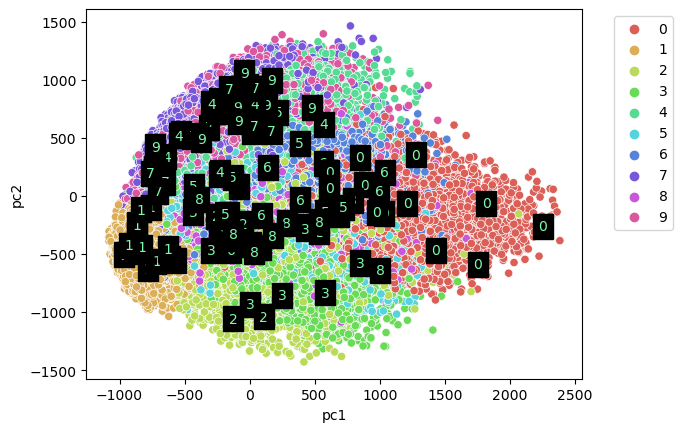

In [49]:
sns.scatterplot(data=reduced, x='pc1', y='pc2', hue='class', palette=pal);
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

labelit=True
if labelit:
    np.random.seed(777)
    rsamp = reduced.sample(100)
    for i in range(rsamp.shape[0]):
        # label the image with the target value
        plt.text(rsamp.iloc[i, 0], rsamp.iloc[i, 1], str(rsamp.iloc[i,2]), color='xkcd:seafoam', backgroundcolor='k')


In [50]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1 Loadings', 'PC2 Loadings'])
loadings

,PC1 Loadings,PC2 Loadings
0,2.448240e-18,-6.177071e-17
1,5.532097e-18,-9.582789e-17
2,-1.993236e-18,-1.913959e-17
3,-9.736447e-19,-1.255857e-17
4,5.725982e-20,-6.122747e-19
...,...,...
779,6.510116e-08,1.900452e-06
780,0.000000e+00,0.000000e+00
781,0.000000e+00,0.000000e+00
782,0.000000e+00,0.000000e+00


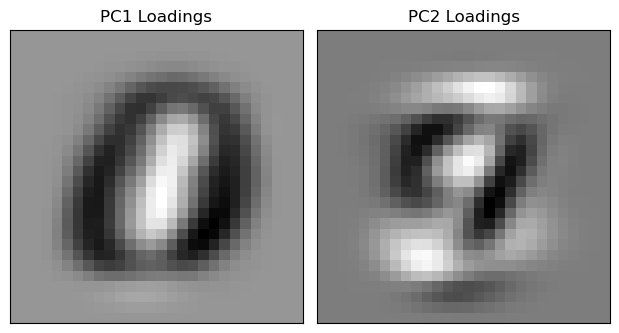

In [51]:
fig = plt.figure(figsize=(6, 3))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.imshow(loadings.loc[:,'PC1 Loadings'].to_numpy().reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')
ax.set_title('PC1 Loadings')

ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.imshow(loadings.loc[:,'PC2 Loadings'].to_numpy().reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')
ax.set_title('PC2 Loadings');


### Task 2: LDA classification

In [54]:
X_train, X_test, y_train, y_test = train_test_split( dataset, target, test_size=0.3, random_state=42)
lda.fit(X_train, y_train)
prediction = lda.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2058
           1       0.86      0.96      0.91      2364
           2       0.91      0.81      0.85      2133
           3       0.85      0.84      0.85      2176
           4       0.84      0.89      0.87      1936
           5       0.83      0.82      0.82      1915
           6       0.93      0.91      0.92      2088
           7       0.93      0.84      0.88      2248
           8       0.80      0.78      0.79      1992
           9       0.79      0.86      0.83      2090

    accuracy                           0.87     21000
   macro avg       0.87      0.87      0.87     21000
weighted avg       0.87      0.87      0.87     21000



Confusion matrix:
[[1940    2    9    5   11   40   23    1   25    2]
 [   0 2266    8   18    2   15    1    3   46    5]
 [  26   81 1723   71   44   15   65   12   89    7]
 [   5   32   58 1833   10   78    7   38   63   52]
 [   1   20   15    0 1728   13    6    1   25  127]
 [  19   24   12  104   20 1561   31   11   97   36]
 [  16   25   31    0   46   44 1908    0   17    1]
 [  15   54   17   20   57    6    0 1891   10  178]
 [  11  126   16   76   24   96   12    3 1556   72]
 [  14   11    9   29  108    8    0   81   23 1807]]


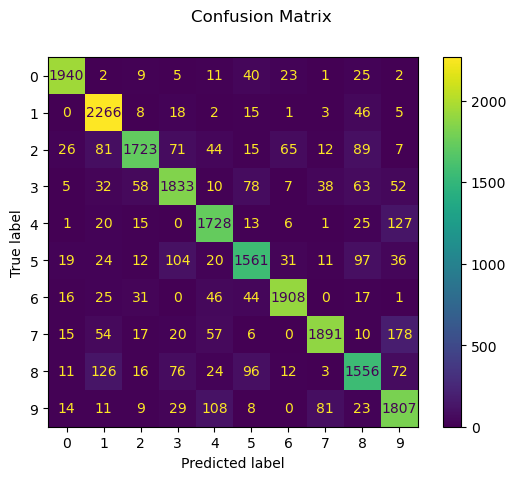

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay 

disp = ConfusionMatrixDisplay.from_predictions(y_test, prediction)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

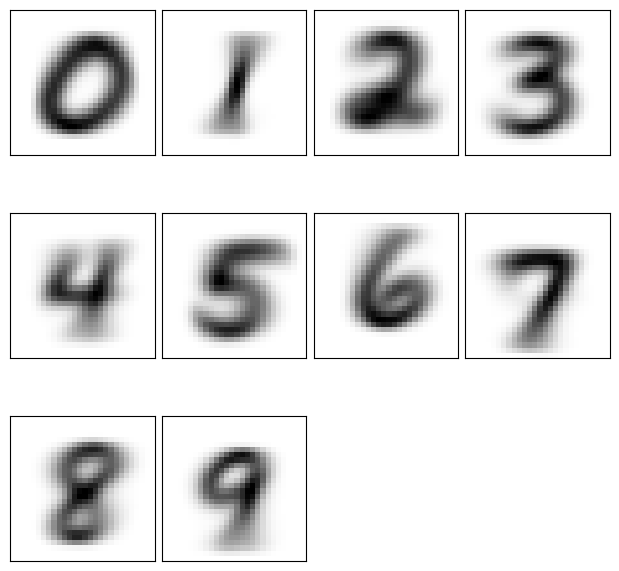

In [65]:
# LDA class means

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    # data is 28 x 28 pixels, grayscale
    ax.imshow(lda.means_[i,:].reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    


In [60]:
lda.

array([[-7.97846875e-18,  5.49695364e-16, -1.97888806e-16,
         2.45276448e-16,  9.50563539e-17, -2.46356826e-16,
         2.32005615e-16,  3.48807440e-16,  7.43892153e-17,
        -8.44071780e-18,  6.47389888e-16,  6.83587697e-17,
         3.74409225e-02,  9.23324775e-03, -2.02444276e-03,
        -4.85866262e-02, -6.05157422e-17, -5.84764852e-17,
         3.37218552e-16,  3.14913088e-17,  6.05582887e-16,
        -5.23031743e-16, -1.03623556e-16, -2.06233611e-16,
        -3.74087236e-16,  6.12196881e-17,  5.92770522e-16,
         9.29623928e-17],
       [-5.99668064e-16,  5.00095804e-16,  1.24121151e-16,
        -4.32082785e-16,  2.46785915e+00, -8.67179525e-01,
         1.51423891e-01, -3.36158734e-02,  2.24500523e-02,
         1.22817872e-02,  4.63402312e-03,  6.25327184e-03,
         2.10669908e-03,  1.12489568e-02, -6.19974826e-03,
         6.02566265e-03,  1.82426520e-03,  1.51765779e-03,
         4.12424461e-03, -2.30640022e-04,  5.49128964e-03,
         1.21028797e-02, -4.14